In [1]:
import numpy as np
import sys
import time
import h5py as h5
import matplotlib.pyplot as plt

sys.path.append(r"C:\Users\haoyuan\Documents\GitHub\CrystalDiff")

from CrystalDiff import util, pulse, lclsutil, groutine, crystal

# Get the Crystal Geometries

In [2]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Pulse
# ----------------------------------------------------------------------------------------------------------

energy_center = 10.
pre_length = 1e6

# Set up the pulse
my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[0., 1., 0.],
                              sigma_x=708.2581446128465,
                              sigma_y=708.2581446128465,
                              sigma_z=1.,
                              x0=np.array([0., 0., -pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Split
# ----------------------------------------------------------------------------------------------------------
dtheta = np.arctan(1.5 * 1e-3 / 5.)      # This is the deviation angle.

grating_list = [crystal.RectangleGrating(), crystal.RectangleGrating()]
grating_list[0].set_a(util.get_grating_period(dtheta=dtheta, klen_in=my_pulse.klen0) / 2)
grating_list[0].set_b(util.get_grating_period(dtheta=dtheta, klen_in=my_pulse.klen0) / 2)

grating_list[1].set_a(util.get_grating_period(dtheta=dtheta, klen_in=my_pulse.klen0) / 2)
grating_list[1].set_b(util.get_grating_period(dtheta=dtheta, klen_in=my_pulse.klen0) / 2)

# ----------------------------------------------------------------------------------------------------------
#                       Step 3: Delay Lines
# ----------------------------------------------------------------------------------------------------------
# Some meta data for the delay line.
reflect_num = 4
h_length = 2. * np.pi / (1.9201 * 1e-4)
hlen_vals = np.array([h_length, ] * reflect_num)

# Some crystal properties
chi0=complex(-0.97631E-05, 0.14871E-06)
chih_sigma=complex(0.59310E-05, -0.14320E-06)
chihbar_sigma=complex(0.59310E-05, -0.14320E-06)
chih_pi=complex(0.46945E-05, -0.11201E-06)
chihbar_pi=complex(0.46945E-05, -0.11201E-06)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal to fix the shearing
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_0 = 0.
bragg_angle_0 = np.radians(18.836) + 13e-6

branch_angle_0 = lclsutil.get_delay_line_angles(angle_offset=angle_offset_0,
                                                theta=bragg_angle_0 + np.pi / 2. ,
                                                rho=bragg_angle_0 - np.pi / 2. ,
                                                inclined_angle=np.radians(-10.))
surface_points_0 = np.zeros((reflect_num, 3), dtype=np.float64)

# Set the misalignment angle
misalign_branch_0_crystal_1 = [0., 0., 0.]
misalign_branch_0_crystal_2 = [0., 0., 0.]

# Initialize the crystals
shear_fix_crystal = lclsutil.get_crystal_list_delay_branch(hlen_vals=hlen_vals,
                                                        theta_vals=branch_angle_0[0],
                                                        rho_vals=branch_angle_0[1],
                                                        tau_vals=branch_angle_0[2],
                                                        surface_points=surface_points_0,
                                                        chi0=chi0,
                                                        chih_sigma=chih_sigma, chihbar_sigma=chihbar_sigma,
                                                        chih_pi=chih_pi, chihbar_pi=chihbar_pi)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  1
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_1 = dtheta
bragg_angle_1 = np.radians(18.836) + 13e-6

branch_angle_1 = lclsutil.get_delay_line_angles(angle_offset=angle_offset_1,
                                                theta=bragg_angle_1 + np.pi / 2. ,
                                                rho=bragg_angle_1 - np.pi / 2. ,
                                                inclined_angle=np.radians(10.))
surface_points_1 = np.zeros((reflect_num, 3), dtype=np.float64)

# Set the misalignment angle
misalign_branch_1_crystal_1 = [0., 0., 0.]
misalign_branch_1_crystal_2 = [0., 0., 0.]

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list_delay_branch(hlen_vals=hlen_vals,
                                                        theta_vals=branch_angle_1[0],
                                                        rho_vals=branch_angle_1[1],
                                                        tau_vals=branch_angle_1[2],
                                                        surface_points=surface_points_1,
                                                        chi0=chi0,
                                                        chih_sigma=chih_sigma, chihbar_sigma=chihbar_sigma,
                                                        chih_pi=chih_pi, chihbar_pi=chihbar_pi)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  2
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_2 = - dtheta
bragg_angle_2 = np.radians(18.836) + 13e-6

branch_angle_2 = lclsutil.get_delay_line_angles(angle_offset=angle_offset_2,
                                                theta=1.5 * np.pi - bragg_angle_2,
                                                rho=0.5 * np.pi - bragg_angle_2,
                                                inclined_angle=np.radians(-10.))
surface_points_2 = np.zeros((reflect_num, 3), dtype=np.float64)

# Set the misalignment angle
misalign_branch_2_crystal_1 = [0., 0., 0.]
misalign_branch_2_crystal_2 = [0., 0., 0.]

# Initialize the crystals
crystal_list_2 = lclsutil.get_crystal_list_delay_branch(hlen_vals=hlen_vals,
                                                        theta_vals=branch_angle_2[0],
                                                        rho_vals=branch_angle_2[1],
                                                        tau_vals=branch_angle_2[2],
                                                        surface_points=surface_points_2,
                                                        chi0=chi0,
                                                        chih_sigma=chih_sigma, chihbar_sigma=chihbar_sigma,
                                                        chih_pi=chih_pi, chihbar_pi=chihbar_pi)


# ------------------------------------------------------
#   Define the positions
# ------------------------------------------------------
path_list_0 = [0., 1e5, 1e5, 1e5]
dist_shear_crystal_grating = 5e5

path_list_1 = [5e6 - 10e4, 1e5, 5e5, 1.05e5, 6e6, 1e6]
path_list_2 = [5e6, 1e5, 1e5, 1.05e5, 6e6, 1e6]
delay_time = 600.

# Arrange the crystals

In [3]:
# Get the positions for the shearing fix branch
(intersect_branch_0,
kout_branch_0) = lclsutil.get_point_with_definite_path(kin_vec = my_pulse.k0,
                                                       path_sections = path_list_0,
                                                       crystal_list = shear_fix_crystal)

# Adjust the path sections
(path_list_1,
 path_list_2) = lclsutil.get_split_delay_configuration(delay_time=delay_time,
                                                       fix_branch_path=path_list_2,
                                                       var_branch_path=path_list_1,
                                                       fix_branch_crystal=crystal_list_2,
                                                       var_branch_crystal=crystal_list_1,
                                                       grating_pair=grating_list,
                                                       kin=kout_branch_0[-1])

(intersect_branch_1,
 kout_brunch_1,
 intersect_branch_2,
 kout_brunch_2) = lclsutil.get_light_path(kin=kout_branch_0[-1],
                                          grating_list=grating_list,
                                          crystal_list_1=crystal_list_1,
                                          path_list_1=path_list_1,
                                          crystal_list_2=crystal_list_2,
                                          path_list_2=path_list_2)

#"""
# Shift the intersection points due to the insertion of the new unit
shift = intersect_branch_0[-1] + dist_shear_crystal_grating * kout_branch_0[-1] / util.l2_norm(kout_branch_0[-1])
intersect_branch_1 += shift[np.newaxis, :]
intersect_branch_2 += shift[np.newaxis, :]


# Initialize the crystals
shear_fix_crystal = lclsutil.get_crystal_list_delay_branch(hlen_vals=hlen_vals,
                                                        theta_vals=branch_angle_0[0],
                                                        rho_vals=branch_angle_0[1],
                                                        tau_vals=branch_angle_0[2],
                                                        surface_points=np.copy(intersect_branch_0),
                                                        chi0=chi0,
                                                        chih_sigma=chih_sigma, chihbar_sigma=chihbar_sigma,
                                                        chih_pi=chih_pi, chihbar_pi=chihbar_pi)

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list_delay_branch(hlen_vals=hlen_vals,
                                                        theta_vals=branch_angle_1[0],
                                                        rho_vals=branch_angle_1[1],
                                                        tau_vals=branch_angle_1[2],
                                                        surface_points=np.copy(intersect_branch_1[1:5]),
                                                        chi0=chi0,
                                                        chih_sigma=chih_sigma, chihbar_sigma=chihbar_sigma,
                                                        chih_pi=chih_pi, chihbar_pi=chihbar_pi)
# Initialize the crystals
crystal_list_2 = lclsutil.get_crystal_list_delay_branch(hlen_vals=hlen_vals,
                                                        theta_vals=branch_angle_2[0],
                                                        rho_vals=branch_angle_2[1],
                                                        tau_vals=branch_angle_2[2],
                                                        surface_points=np.copy(intersect_branch_2[1:5]),
                                                        chi0=chi0,
                                                        chih_sigma=chih_sigma, chihbar_sigma=chihbar_sigma,
                                                        chih_pi=chih_pi, chihbar_pi=chihbar_pi)

grating_list[0].set_surface_point(np.copy(intersect_branch_2[0]))
grating_list[1].set_surface_point(np.copy(intersect_branch_2[-2]))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the observation point
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
observation = np.copy(intersect_branch_2[-1]) 
total_path = pre_length + np.sum(path_list_2) + np.sum(path_list_0) + dist_shear_crystal_grating

print("The total propagation length is {:.2f}m.".format(total_path / 1e6))
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Change frame
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# 
(my_pulse,
 shear_fix_crystal,
 crystal_list_1,
 crystal_list_2,
 grating_list,
 observation
) = lclsutil.get_split_delay_fix_shear_output_frame(displacement=-np.copy(intersect_branch_2[-1]),
                                                    observe=observation,
                                                    pulse=my_pulse,
                                                    crystal_fix_shear = shear_fix_crystal,
                                                    crystal_list_1=crystal_list_1,
                                                    crystal_list_2=crystal_list_2,
                                                    grating_pair=grating_list)

# 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Get the momentum mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
number_x = 2
number_y = 250
number_z = 10 ** 5
kx_grid, ky_grid, kz_grid, axis_info = lclsutil.get_k_mesh_3d(number_x=number_x,
                                                              number_y=number_y,
                                                              number_z=number_z,
                                                              delta_e_x=1e-50,
                                                              delta_e_y=0.75e-4,
                                                              delta_e_z=1e-4 / util.c)
kz_grid += my_pulse.klen0

# Apply fft shift
# kx_grid = np.ascontiguousarray(np.fft.fftshift(kx_grid))
kx_grid = np.zeros(1, np.float64)
number_x = 1
ky_grid = np.ascontiguousarray(np.fft.fftshift(ky_grid))
kz_grid = np.ascontiguousarray(np.fft.fftshift(kz_grid))
#"""

The total propagation length is 13.00m.


In [4]:
holder = np.zeros(3)

for x in crystal_list_1:
    print(x.normal)
    holder += x.normal

[ 0.         -0.94634549  0.32315665]
[ 0.17364818  0.93196837 -0.31824718]
[0.17364818 0.93215915 0.31768794]
[ 0.         -0.94653921 -0.32258879]


In [5]:
holder

array([ 3.47296355e-01, -2.87571718e-02,  8.62715155e-06])

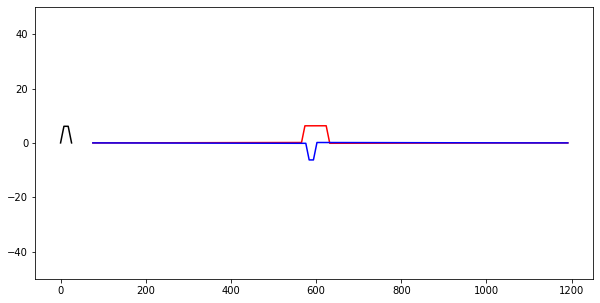

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

axes.plot(intersect_branch_1[:,2]/1e4, intersect_branch_1[:,1]/1e4,'r')
axes.plot(intersect_branch_2[:,2]/1e4, intersect_branch_2[:,1]/1e4,'b')
axes.plot(intersect_branch_0[:,2]/1e4, intersect_branch_0[:,1]/1e4,'k')

#axes.set_xlim([5e2-70, 5e2 + 150])
axes.set_ylim([-50, 50])
#axes.set_aspect('equal', 'datalim')

plt.show()

In [7]:
# Set the range of the index to save
z_idx_range = 300
num1 = 250
num2 = 50
d_num = 512

# -------------------------------------------------------------
#            Get Field for Branch 2
# -------------------------------------------------------------
tic = time.time()

(result_3d_dict_2,
 result_2d_dict_2,
 check_dict_2
) = groutine.get_split_delay_single_branch_field_shear_fix(grating_pair = grating_list,
                                                           shear_fix_crystals = shear_fix_crystal,
                                                           channel_cuts = crystal_list_2,
                                                           total_path = total_path, 
                                                           observation = observation,
                                                           my_pulse = my_pulse,
                                                           kx_grid = kx_grid,
                                                           ky_grid = ky_grid,
                                                           kz_grid = kz_grid,
                                                           pulse_delay_time = 0.,
                                                           pulse_k0_final = np.array([0.,0.,my_pulse.klen0]),
                                                           grating_orders = [-1., 1.],
                                                           number_x = number_x,
                                                           number_y = number_y,
                                                           number_z = number_z,
                                                           z_idx_range = z_idx_range,
                                                           num1 = num1,
                                                           num2 = num2, 
                                                           d_num = 512)

toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 1.".format(toc - tic))

It takes 0.04 seconds to prepare the variables.
It takes 18.34 seconds to get the field for branch 1.


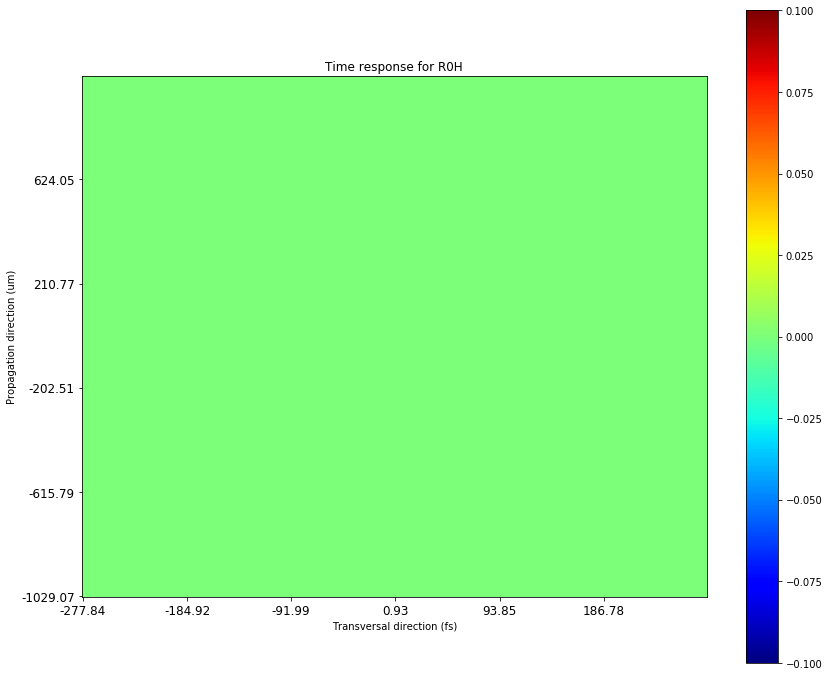

In [8]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(12)
fig.set_figwidth(14)

ratio = (((axis_info['z_idx'][z_idx_range - 1] - axis_info['z_idx'][0]) /z_idx_range) /
         ((axis_info['y_idx'][-1] - axis_info['y_idx'][0]) / number_y))

field_2 = np.fft.ifftshift(np.fft.ifft(result_2d_dict_2['y_field_2d'], axis=0), axes=0)

im = axes.imshow(np.abs( field_2 ),
                 #vmin=  17,
                 #vmax = 25.,
                 cmap='jet', 
                 origin='lower',
                 #aspect = 1/util.c,
                 )

axes.set_title("Time response for R0H")
axes.set_yticks(np.arange(0, number_y, step=50))
axes.set_yticklabels(axis_info["y_idx_tick"][::50], fontsize=12)
axes.set_xticks(np.arange(0, z_idx_range, step=50))
axes.set_xticklabels(axis_info["z_idx_tick"][number_z//2 - z_idx_range//2:
                                              number_z//2 + z_idx_range//2:50], fontsize=12)

axes.set_ylabel("Propagation direction (um)")
axes.set_xlabel("Transversal direction (fs)")
fig.colorbar(im, ax=axes)
# Show the canvas

plt.show()

In [9]:
# -------------------------------------------------------------
#            Get Field for Branch 2
# -------------------------------------------------------------
tic = time.time()

(result_3d_dict_1,
 result_2d_dict_1,
 check_dict_1
) = groutine.get_split_delay_single_branch_field_shear_fix(grating_pair = grating_list,
                                                           shear_fix_crystals = shear_fix_crystal,
                                                           channel_cuts = crystal_list_1,
                                                           total_path = total_path, 
                                                           observation = observation,
                                                           my_pulse = my_pulse,
                                                           kx_grid = kx_grid,
                                                           ky_grid = ky_grid,
                                                           kz_grid = kz_grid,
                                                           pulse_delay_time = 0.,
                                                           pulse_k0_final = np.array([0.,0.,my_pulse.klen0]),
                                                           grating_orders = [1., -1.],
                                                           number_x = number_x,
                                                           number_y = number_y,
                                                           number_z = number_z,
                                                           z_idx_range = z_idx_range,
                                                           num1 = num1,
                                                           num2 = num2, 
                                                           d_num = 512)

toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 1.".format(toc - tic))

It takes 0.03 seconds to prepare the variables.
It takes 17.97 seconds to get the field for branch 1.


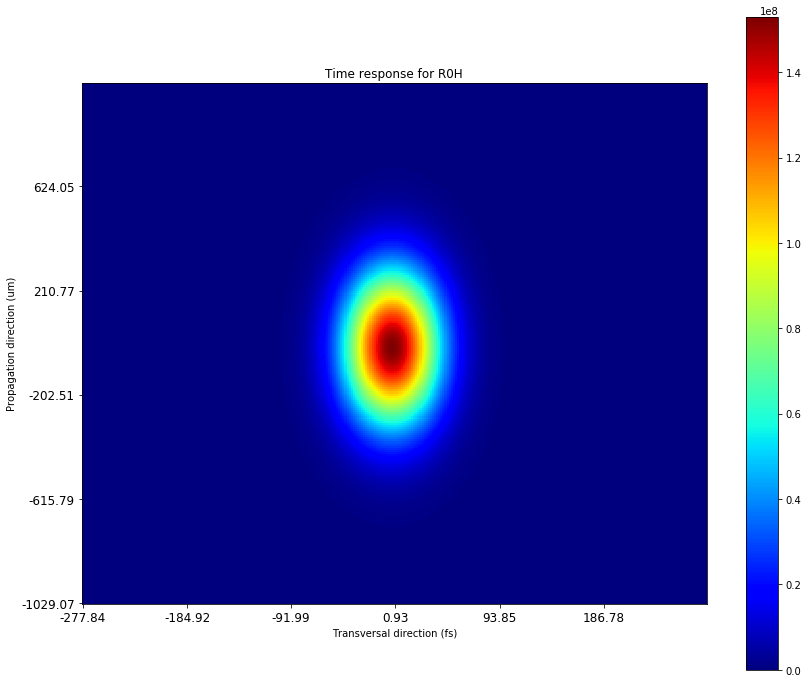

In [10]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(12)
fig.set_figwidth(14)

ratio = (((axis_info['z_idx'][z_idx_range - 1] - axis_info['z_idx'][0]) /z_idx_range) /
         ((axis_info['y_idx'][-1] - axis_info['y_idx'][0]) / number_y))

field_1 = np.fft.ifftshift(np.fft.ifft(result_2d_dict_1['y_field_2d'], axis=0), axes=0)

im = axes.imshow(np.abs( field_1 ),
                 #vmin=  17,
                 #vmax = 25.,
                 cmap='jet', 
                 origin='lower',
                 #aspect = 1/util.c,
                 )

axes.set_title("Time response for R0H")
axes.set_yticks(np.arange(0, number_y, step=50))
axes.set_yticklabels(axis_info["y_idx_tick"][::50], fontsize=12)
axes.set_xticks(np.arange(0, z_idx_range, step=50))
axes.set_xticklabels(axis_info["z_idx_tick"][number_z//2 - z_idx_range//2:
                                              number_z//2 + z_idx_range//2:50], fontsize=12)

axes.set_ylabel("Propagation direction (um)")
axes.set_xlabel("Transversal direction (fs)")
fig.colorbar(im, ax=axes)
# Show the canvas

plt.show()

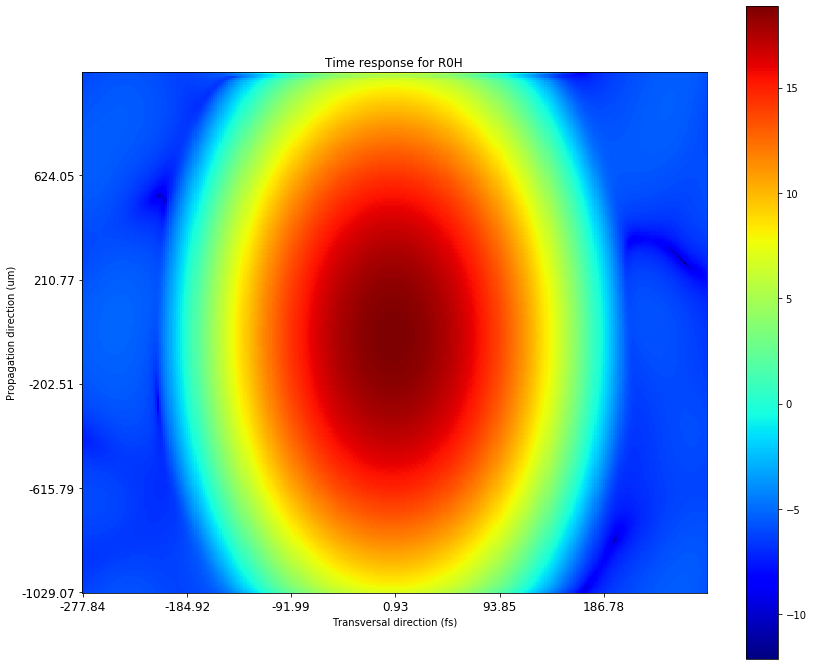

In [11]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(12)
fig.set_figwidth(14)

ratio = (((axis_info['z_idx'][z_idx_range - 1] - axis_info['z_idx'][0]) /z_idx_range) /
         ((axis_info['y_idx'][-1] - axis_info['y_idx'][0]) / number_y))

field_1 = np.fft.ifftshift(np.fft.ifft(result_2d_dict_1['y_field_2d'], axis=0), axes=0)

im = axes.imshow(np.log(np.abs( field_1 + field_2 )),
                 #vmin=  17,
                 #vmax = 25.,
                 cmap='jet', 
                 origin='lower',
                 #aspect = 1/util.c,
                 )

axes.set_title("Time response for R0H")
axes.set_yticks(np.arange(0, number_y, step=50))
axes.set_yticklabels(axis_info["y_idx_tick"][::50], fontsize=12)
axes.set_xticks(np.arange(0, z_idx_range, step=50))
axes.set_xticklabels(axis_info["z_idx_tick"][number_z//2 - z_idx_range//2:
                                              number_z//2 + z_idx_range//2:50], fontsize=12)

axes.set_ylabel("Propagation direction (um)")
axes.set_xlabel("Transversal direction (fs)")
fig.colorbar(im, ax=axes)
# Show the canvas

plt.show()